In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CocoFourClassDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):

        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name, label = self.annotations[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [2]:
!mkdir ./coco
!mkdir ./coco/images
!mkdir ./coco/annotations

In [ ]:
!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip train2017.zip -d ./coco/images/
!unzip val2017.zip -d ./coco/images/
!unzip annotations_trainval2017.zip -d ./coco/

In [ ]:
!pip install pycocotools

In [44]:
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print(category_names)  # Ensure correct class names

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [2]:
def get_single_category_images(coco, category_name):
    cat_id = coco.getCatIds(catNms=[category_name])[0]
    img_ids = coco.getImgIds(catIds=[cat_id])

    filtered_img_ids = []
    for img_id in img_ids:
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        all_cats = {ann['category_id'] for ann in anns}

        # Ensure only the desired category is present
        if len(all_cats) == 1 and cat_id in all_cats:
            filtered_img_ids.append(img_id)

    return filtered_img_ids
# coco = COCO("/content/coco/annotations/instances_train2017.json")
# people_images = get_single_category_images(coco, 'boat')
# print(f"Filtered People Images: {len(people_images)}")
# # people_images

In [3]:
from pycocotools.coco import COCO

COCO_TRAIN_ANNOTATIONS = "/content/coco/annotations/instances_train2017.json"
COCO_IMAGES_TRAIN = "/content/coco/images/"
COCO_VAL_ANNOTATIONS = "/content/coco/annotations/instances_val2017.json"
COCO_IMAGES_VAL = "/content/coco/images/"


annotation_file = '/content/annotation_train.txt'
classes = ['bird', 'airplane', 'train', 'boat']
coco = COCO(COCO_TRAIN_ANNOTATIONS)
with open(annotation_file, "w+") as f:
  for coco_class in classes:
    # img_ids = coco.getImgIds(catIds=coco.getCatIds(catNms=coco_class))
    img_ids = get_single_category_images(coco, coco_class)
    for i in range(len(img_ids)):
      image_name = str(img_ids[i]).rjust(12, '0')
      f.write(f"{image_name}.jpg {classes.index(coco_class)}\n")

annotation_file = '/content/annotation_val.txt'
coco = COCO(COCO_VAL_ANNOTATIONS)
with open(annotation_file, "w+") as f:
  for coco_class in classes:
    img_ids = get_single_category_images(coco, coco_class)
    for i in range(len(img_ids)):
      image_name = str(img_ids[i]).rjust(12, '0')
      f.write(f"{image_name}.jpg {classes.index(coco_class)}\n")


loading annotations into memory...
Done (t=15.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [4]:
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            img_filename = parts[0]
            label = int(parts[1])  # Convert string label to integer
            annotations.append((img_filename, label))
    return annotations


In [5]:
from torchvision.datasets import ImageFolder
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

annotations_train = load_annotations("/content/annotation_train.txt")
annotations_val = load_annotations("/content/annotation_val.txt")
training_data = CocoFourClassDataset(image_dir='/content/coco/images/train2017/', annotations=annotations_train,
                    transform=train_transforms)
val_data = CocoFourClassDataset(image_dir='/content/coco/images/val2017/', annotations=annotations_val,
                    transform=val_transforms)
from torch.utils.data import DataLoader



train_dataloader = DataLoader(training_data, batch_size=2048, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=2048, shuffle=True, num_workers=8, pin_memory=True)



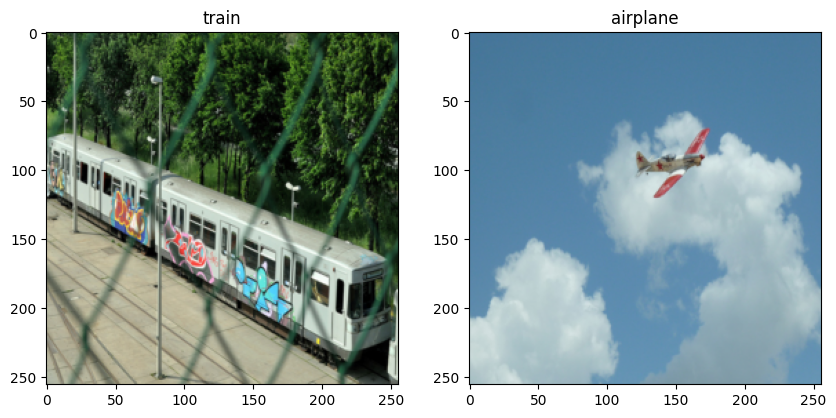

In [17]:
# Visualization

import matplotlib.pyplot as plt

def show_img_example(dataloader):



  fig, ax = plt.subplots(1, 2, figsize=(10, 10))
  for i in range(2):
    image_tensor, labels = next(iter(dataloader))
    image = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    label_id = labels[0].item()
    ax[i].imshow(image)
    ax[i].title.set_text(classes[label_id])
  plt.show()
  return

view_transforms = transforms.Compose([
    transforms.Resize((256, 256)), transforms.ToTensor()])
train_data = CocoFourClassDataset(image_dir='/content/coco/images/train2017/', annotations=annotations_train,transform=view_transforms)

view_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

show_img_example(view_dataloader)

In [37]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet50
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze only layer3 and layer4
for param in resnet50.layer3.parameters():
    param.requires_grad = True

for param in resnet50.layer4.parameters():
    param.requires_grad = True

# Replace the final fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 4)  # 4 classes: 'bird', 'airplane', 'train', 'truck'
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50.to(device)
print("Cuda is available:", torch.cuda.is_available())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Cuda is available: True


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

##出現提示欄進行授權

os.chdir('/content/drive/My Drive/') #切換該目錄
os.listdir() #確認目錄內容

In [21]:
def save_checkpoint(model, optimizer, epoch, filepath="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}")
    return


def load_checkpoint(model, optimizer, filepath="best_model.pth"):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']

    return start_epoch


In [22]:
# Training

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("/content/drive/MyDrive/coco_four_classification")


num_epochs = 70
best_val_accuracy = 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, num_epochs+1):
  model.train()
  running_loss = 0.0
  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    # loss.backward()
    # optimizer.step()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    running_loss += loss.item() * inputs.size(0)

  epoch_loss = running_loss / len(train_dataloader.dataset)
  print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}")
  scheduler.step(epoch_loss)
  writer.add_scalar("Training Loss", epoch_loss, epoch)

  if epoch % 5 == 0:
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        val_accuracy = correct / total
        print(f"Validation Accuracy after {epoch} epochs: {val_accuracy * 100:.2f}%")

        # Log validation accuracy
        writer.add_scalar("Validation Accuracy", val_accuracy, epoch)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, filepath=f"/content/drive/MyDrive/resnet50_bestmodel_{epoch}.pth")

writer.close()

<ipython-input-22-2eebea9c5d03>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-22-2eebea9c5d03>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/70, Loss: 1.3262
Epoch 2/70, Loss: 1.1745
Epoch 3/70, Loss: 1.0510
Epoch 4/70, Loss: 0.9366
Epoch 5/70, Loss: 0.8285
Validation Accuracy after 5 epochs: 86.05%
Checkpoint saved at epoch 5
Epoch 6/70, Loss: 0.7352
Epoch 7/70, Loss: 0.6575
Epoch 8/70, Loss: 0.5937
Epoch 9/70, Loss: 0.5380
Epoch 10/70, Loss: 0.4922
Validation Accuracy after 10 epochs: 95.93%
Checkpoint saved at epoch 10
Epoch 11/70, Loss: 0.4574
Epoch 12/70, Loss: 0.4287
Epoch 13/70, Loss: 0.4000
Epoch 14/70, Loss: 0.3808
Epoch 15/70, Loss: 0.3684
Validation Accuracy after 15 epochs: 96.51%
Checkpoint saved at epoch 15
Epoch 16/70, Loss: 0.3498
Epoch 17/70, Loss: 0.3430
Epoch 18/70, Loss: 0.3278
Epoch 19/70, Loss: 0.3184
Epoch 20/70, Loss: 0.3040
Validation Accuracy after 20 epochs: 97.09%
Checkpoint saved at epoch 20
Epoch 21/70, Loss: 0.2979
Epoch 22/70, Loss: 0.2875
Epoch 23/70, Loss: 0.2838
Epoch 24/70, Loss: 0.2738
Epoch 25/70, Loss: 0.2772
Validation Accuracy after 25 epochs: 96.51%
Epoch 26/70, Loss: 0.2759

In [23]:
###
import numpy as np


save_checkpoint(model, optimizer, epoch, filepath=f"/content/drive/MyDrive/resnet50_{epoch}.pth")
load_checkpoint(model, optimizer, filepath='/content/drive/MyDrive/resnet50_bestmodel_45.pth')

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.numpy())

from sklearn.metrics import confusion_matrix, classification_report

target_names = ['bird', 'airplane', 'train', 'boat']

conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
print("Confusion Matrix:")
print(conf_matrix)

per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
  print(f"{target_names[i]} accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

Checkpoint saved at epoch 70
Confusion Matrix:
[[49  2  0  0]
 [ 0 49  0  0]
 [ 0  1 48  0]
 [ 0  0  0 23]]
bird accuracy: 96.08%
airplane accuracy: 100.00%
train accuracy: 97.96%
boat accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

        bird       1.00      0.96      0.98        51
    airplane       0.94      1.00      0.97        49
       train       1.00      0.98      0.99        49
        boat       1.00      1.00      1.00        23

    accuracy                           0.98       172
   macro avg       0.99      0.99      0.98       172
weighted avg       0.98      0.98      0.98       172



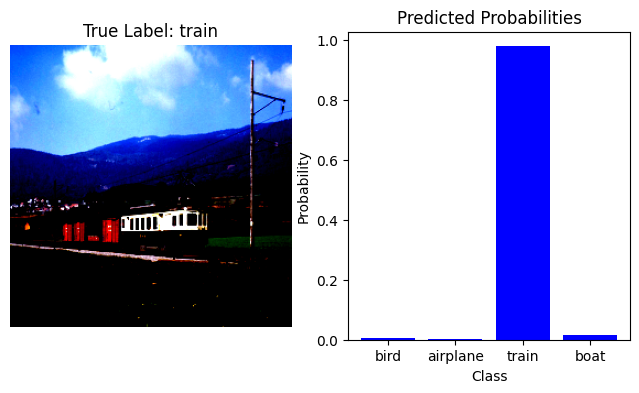

In [30]:
def show_prediction(model, dataloader, device):
    model.eval()  
    inputs, labels = next(iter(dataloader))  
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)  
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  

    # Select the first image in the batch
    img = inputs[0].cpu().numpy().transpose(1, 2, 0) 
    label = labels[0].item()  
    probs = probabilities[0].cpu().numpy()  

    # Plot the image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True Label: {classes[label]}")

    # Plot class probabilities
    plt.subplot(1, 2, 2)
    plt.bar(classes, probs, color='blue')
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title("Predicted Probabilities")

    plt.show()
show_prediction(model, val_dataloader, device)